In [1]:
import torch
from PIL import Image
from torchvision import models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-image==0.19.3
from lime import lime_image
from skimage.segmentation import mark_boundaries

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 20.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.20.0
    Uninstalling scikit-image-0.20.0:
      Successfully uninstalled scikit-image-0.20.0


---
## MobileNet V2

#### Loading Model

In [2]:
%%capture
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

#### Imagenet Classes Dictionary

In [3]:
with open('/kaggle/input/imagenet-classes/imagenet_classes.txt', 'r') as f:
    imagenet_classes = {}
    for i, row in enumerate(f):
        row = row.strip()
        imagenet_classes[i] = row

#### Opening Images

In [4]:
img1 = Image.open('/kaggle/input/mbs-images/sidewinder.jpg').convert('RGB')
img2 = Image.open('/kaggle/input/mbs-images/beacon.jpg').convert('RGB')
img3 = Image.open('/kaggle/input/mbs-images/musical-instruments.jpg').convert('RGB')

#### Transformations

In [5]:
transformations = [transforms.Resize((256, 256)),
                   transforms.CenterCrop(224),
                   transforms.ToTensor(),
                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

def transform(transformations):
    return transforms.Compose(transformations)

In [6]:
img_1 = transform(transformations)(img1).unsqueeze(0)
img_2 = transform(transformations)(img2).unsqueeze(0)
img_3 = transform(transformations)(img3).unsqueeze(0)

---
## Model Top 5 Probable Outputs

#### Sidewinder:

In [7]:
logits1 = model(img_1)
probs1 = F.softmax(logits1, dim=1)
probs1_5 = probs1.topk(5)
(tuple((p,c, imagenet_classes[c]) for p, c in zip(probs1_5[0][0].detach().numpy(), probs1_5[1][0].detach().numpy())))

((0.6478405, 66, 'horned viper'),
 (0.32613173, 68, 'sidewinder'),
 (0.013589431, 34, 'leatherback turtle'),
 (0.0027936043, 616, 'knot'),
 (0.0018535309, 65, 'sea snake'))

#### Beacon:

In [8]:
logits2 = model(img_2)
probs2 = F.softmax(logits2, dim=1)
probs2_5 = probs2.topk(5)
tuple((p,c, imagenet_classes[c]) for p, c in zip(probs2_5[0][0].detach().numpy(), probs2_5[1][0].detach().numpy()))

((0.8839334, 437, 'beacon'),
 (0.082126535, 460, 'breakwater'),
 (0.010992705, 540, 'drilling platform'),
 (0.0069807284, 510, 'container ship'),
 (0.0052685714, 833, 'submarine'))

#### Musical Instruments:

In [9]:
logits3 = model(img_3)
probs3 = F.softmax(logits3, dim=1)
probs3_5 = probs3.topk(5)
tuple((p,c, imagenet_classes[c]) for p, c in zip(probs3_5[0][0].detach().numpy(), probs3_5[1][0].detach().numpy()))

((0.7117781, 486, 'cello'),
 (0.19297945, 889, 'violin'),
 (0.015977144, 819, 'stage'),
 (0.013588687, 402, 'acoustic guitar'),
 (0.01138448, 420, 'banjo'))

---
## LIME

#### Building Classifier from Model

In [10]:
def classifier(images):
    model.eval()
    
    batch = torch.stack(tuple(transform(transformations[2:])(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

#### Explanations

In [11]:
# sidewinder #
explainer1 = lime_image.LimeImageExplainer()
explanation1 = explainer1.explain_instance(np.array(transform(transformations[:2])(img1)), 
                                           classifier, # classification function
                                           top_labels=5, 
                                           hide_color=0, 
                                           num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
# beacon #
explainer2 = lime_image.LimeImageExplainer()
explanation2 = explainer2.explain_instance(np.array(transform(transformations[:2])(img2)), 
                                           classifier, # classification function
                                           top_labels=5, 
                                           hide_color=0, 
                                           num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
# musical instruments #
explainer3 = lime_image.LimeImageExplainer()
explanation3 = explainer3.explain_instance(np.array(transform(transformations[:2])(img3)), 
                                           classifier, # classification function
                                           top_labels=5, 
                                           hide_color=0, 
                                           num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

---
## Plots

In [14]:
def plots(img, explanation):
    temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    img_boundry1 = mark_boundaries(temp1/255.0, mask1)

    temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    img_boundry2 = mark_boundaries(temp2/255.0, mask2)

    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    plt.subplots(2,2, figsize=(10,10))
    plt.subplot(221)
    plt.imshow(img)
    plt.axis("Off")
    plt.subplot(222)
    plt.imshow(img_boundry1)
    plt.axis("Off")
    plt.subplot(223)
    plt.imshow(img_boundry2)
    plt.axis("Off")
    plt.subplot(224)
    sns.heatmap(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max(), square=True)
    plt.axis("Off")
    plt.tight_layout(pad=1)

#### Sidewinder:

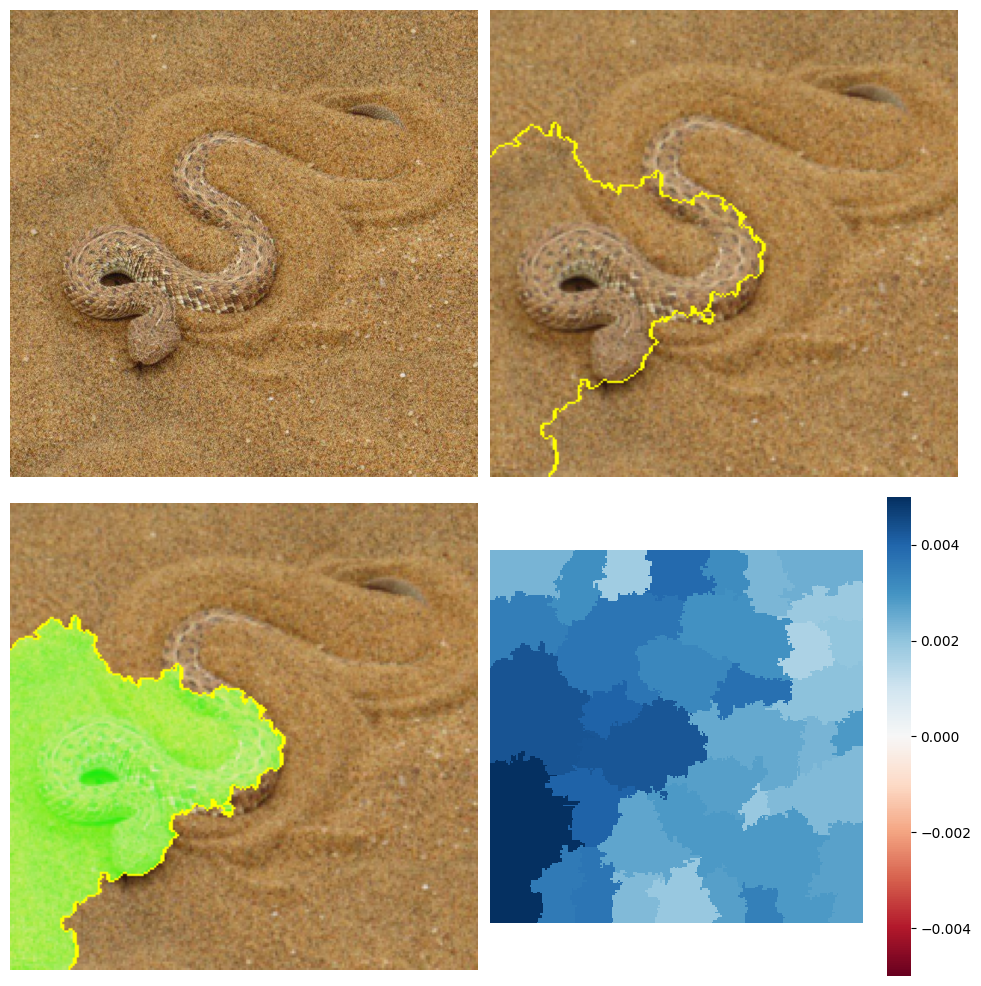

In [15]:
plots(img1, explanation1)

#### Beacon:

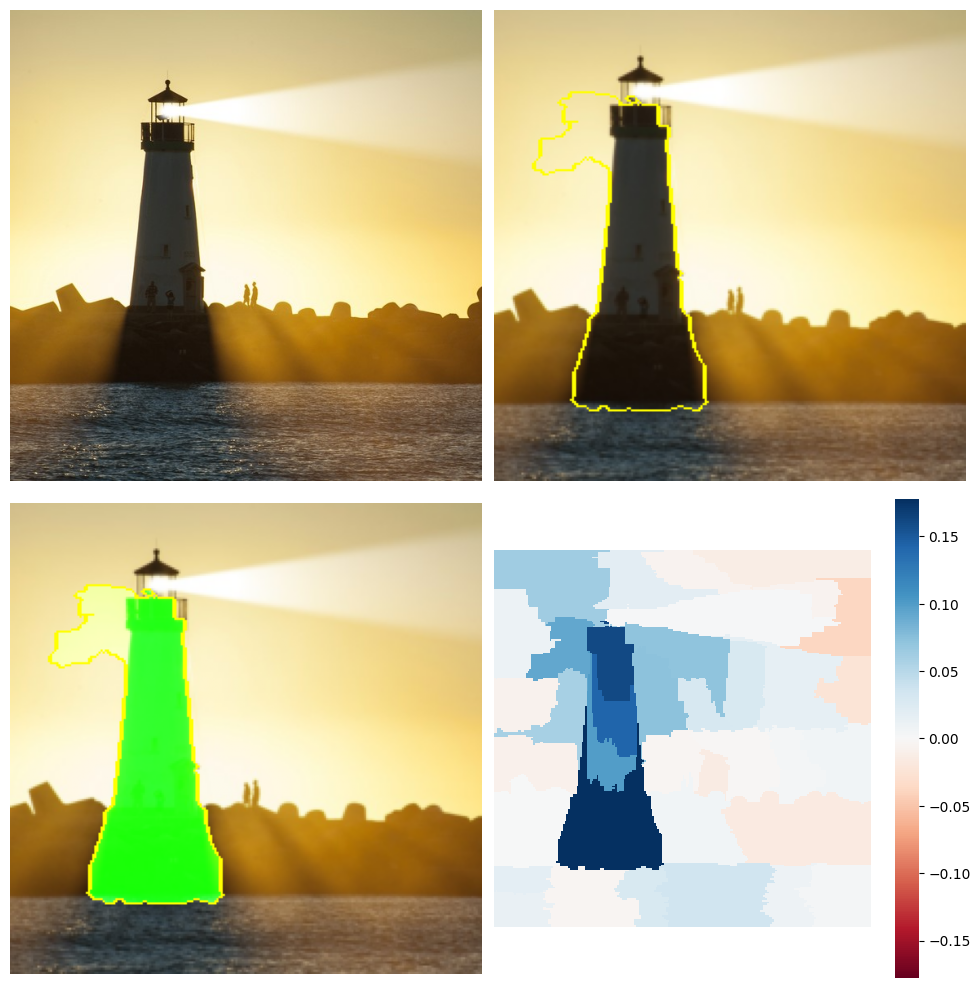

In [16]:
plots(img2, explanation2)

#### Musical Instruments

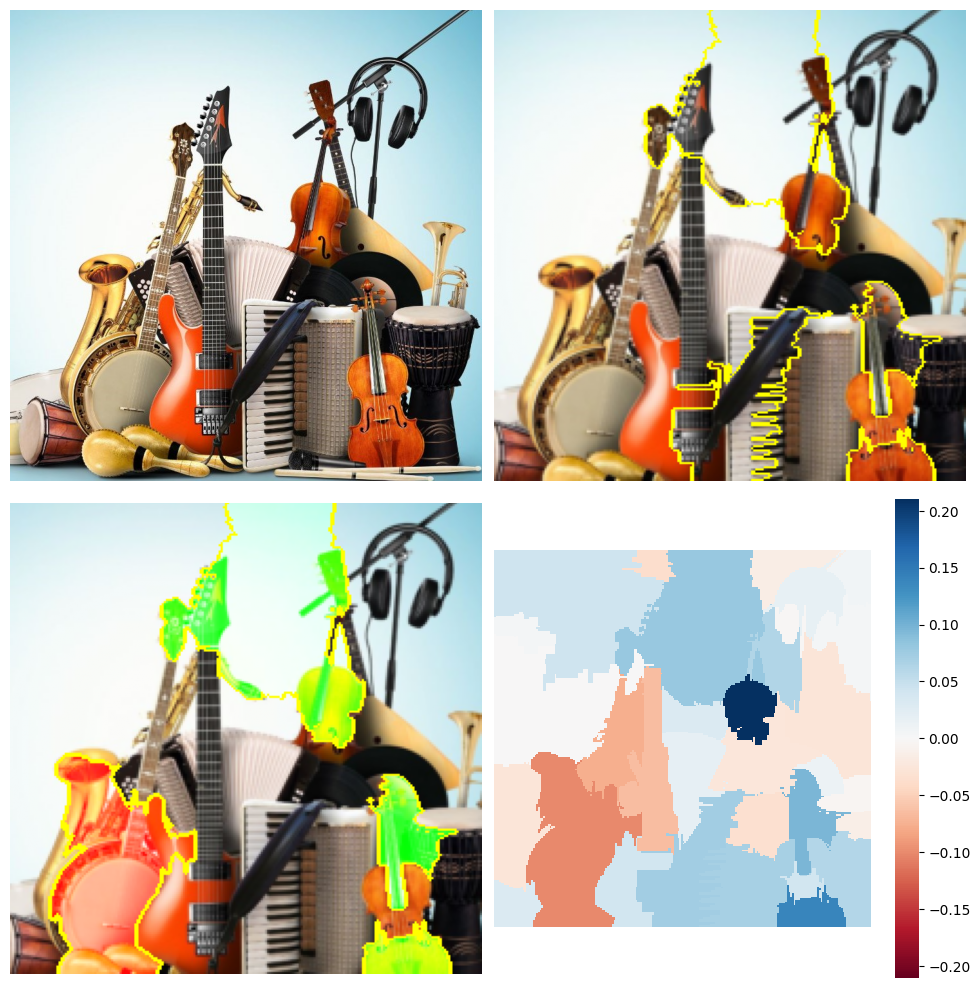

In [17]:
plots(img3, explanation3)

---

<div align=center lang="fa"><font face="Tahoma" size="5" color=#c4c4c4>End</font></div>

---